In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath('..'))

# Import preprocessing utilities
from transformer.data_preprocessing import load_and_clean_data, prepare_data_for_modeling

In [3]:
# Define the relative path to the CSV file
file_path = os.path.join('..', 'transformer', 'energy_cleaned.csv')

# Load the data
data = load_and_clean_data(file_path)
print(f"Original dataset shape: {data.shape}")
print(f"Columns with missing values: {data.isna().sum().sum()}")

# Process the data
data = data.copy()

# Columns to drop
# columns_to_drop = ['BESG Environmental Pillar Score',
#                    'BESG Social Pillar Score',
#                    'BESG Governance Pillar Score',
#                    'Revenue, Adj',
#                    'Net Income, Adj',
#                    'Margin %',
#                    'EPS, Adj',
#                    'Market Cap ($M)']

# data = data.drop(columns=columns_to_drop)

# Display the first few rows
data.head()


Original dataset shape: (1224, 141)
Columns with missing values: 84783
Processed dataset shape: (1224, 141)
Columns with missing values after processing: 1224
Original dataset shape: (1224, 141)
Columns with missing values: 1224


,Company,Ticker,Year,BESG ESG Score,BESG Environmental Pillar Score,BESG Social Pillar Score,BESG Governance Pillar Score,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,...,Indep Directors,Raw Materials Used,Percentage Gender Pay Gap Employees Ex Management,Percentage Raw Material from Sustainable Sources,"Revenue, Adj","Net Income, Adj",Margin %,"EPS, Adj",Market Cap ($M),Market Cap Category
0,ACS Actividades de Construccion y Servicios SA,ACS,2014,4.26,3.61,3.31,6.645,50.729,37.511,33.676,...,Yes,55.0,90.09,86.0,NaN,160.5,13.546,0.052,13716.9,Large Cap
1,ACS Actividades de Construccion y Servicios SA,ACS,2015,1.85,0.66,2.38,3.660,55.296,42.616,41.717,...,Yes,55.0,90.09,86.0,NaN,160.5,13.546,0.052,13716.9,Large Cap
2,ACS Actividades de Construccion y Servicios SA,ACS,2016,2.17,1.13,2.37,4.050,55.497,48.354,36.578,...,Yes,55.0,90.09,86.0,NaN,160.5,13.546,0.052,13716.9,Large Cap
3,ACS Actividades de Construccion y Servicios SA,ACS,2017,2.76,1.13,4.30,4.110,57.248,50.317,44.891,...,Yes,55.0,90.09,86.0,NaN,160.5,13.546,0.052,13716.9,Large Cap
4,ACS Actividades de Construccion y Servicios SA,ACS,2018,2.63,1.11,4.20,3.640,62.609,52.280,59.039,...,Yes,55.0,90.09,86.0,NaN,160.5,13.546,0.052,13716.9,Large Cap


In [4]:
class ESGTimeSeriesDataset(Dataset):
    """
    Dataset class for ESG time series data
    """
    def __init__(self, X, y, seq_length=3):
        self.X = X
        self.y = y
        self.seq_length = seq_length

    def __len__(self):
        # We need at least seq_length consecutive samples for each company
        return len(self.X) - self.seq_length + 1

    def __getitem__(self, idx):
        # Get sequence of features and target
        X_seq = self.X[idx:idx+self.seq_length]
        y_target = self.y[idx+self.seq_length-1]

        return {
            'features': torch.tensor(X_seq, dtype=torch.float32),
            'target': torch.tensor(y_target, dtype=torch.float32)
        }


In [5]:
class LSTMModel(nn.Module):
    """
    LSTM model for ESG score prediction
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Fully connected output layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)

        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_length, hidden_size)

        # We only need the last time step output
        out = out[:, -1, :]  # (batch_size, hidden_size)

        # Pass through fully connected layer
        out = self.fc(out)  # (batch_size, output_size)

        return out

In [6]:
def prepare_time_series_data(data, target_col='BESG ESG Score', group_col='Company', time_col='Year'):
    """
    Prepare data for time series modeling by grouping by company and sorting by year
    """
    # Sort data by company and year
    data_sorted = data.sort_values([group_col, time_col])

    # Extract features and target
    X = data.drop([target_col, group_col, time_col], axis=1)
    y = data[target_col].values

    # Get numerical features
    num_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Convert categorical features to one-hot encoding
    X_encoded = pd.get_dummies(X)

    # More aggressive handling of problematic data
    # 1. Replace any string values with 0
    for col in X_encoded.columns:
        if X_encoded[col].dtype == 'object':
            X_encoded[col] = pd.to_numeric(X_encoded[col], errors='coerce')

    # 2. Fill NaN values with 0
    X_encoded = X_encoded.fillna(0)

    # 3. Explicitly convert to float32
    X_scaled = X_encoded.astype(np.float32)

    # Scale numerical features
    scaler = StandardScaler()
    X_scaled[num_features] = scaler.fit_transform(X_encoded[num_features])

    # Ensure all data is numeric and handle NaNs
    X_scaled = X_scaled.fillna(0).astype(np.float32)

    # Create company groups for time series splitting
    company_groups = data[group_col].values

    return X_scaled.values, y, company_groups

# Prepare data
X, y, company_groups = prepare_time_series_data(data)
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (1224, 657)
Target shape: (1224,)


In [7]:
def time_series_company_split(X, y, company_groups, test_size=0.2, val_size=0.1):
    """
    Split data ensuring companies are not split between train/val/test
    """
    unique_companies = np.unique(company_groups)
    n_companies = len(unique_companies)

    # Shuffle companies
    np.random.shuffle(unique_companies)

    # Split companies into train, val, test
    n_test = int(n_companies * test_size)
    n_val = int(n_companies * val_size)

    test_companies = unique_companies[:n_test]
    val_companies = unique_companies[n_test:n_test+n_val]
    train_companies = unique_companies[n_test+n_val:]

    # Create masks
    test_mask = np.isin(company_groups, test_companies)
    val_mask = np.isin(company_groups, val_companies)
    train_mask = np.isin(company_groups, train_companies)

    # Split data
    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[val_mask], y[val_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    return X_train, X_val, X_test, y_train, y_val, y_test

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = time_series_company_split(X, y, company_groups)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Training set: (861, 657)
Validation set: (114, 657)
Test set: (249, 657)


In [8]:
def create_sequence_datasets(X_train, X_val, X_test, y_train, y_val, y_test, seq_length=3):
    """
    Create sequence datasets for LSTM
    """
    train_dataset = ESGTimeSeriesDataset(X_train, y_train, seq_length)
    val_dataset = ESGTimeSeriesDataset(X_val, y_val, seq_length)
    test_dataset = ESGTimeSeriesDataset(X_test, y_test, seq_length)

    return train_dataset, val_dataset, test_dataset

# Create datasets
seq_length = 3  # Number of years to look back
train_dataset, val_dataset, test_dataset = create_sequence_datasets(
    X_train, X_val, X_test, y_train, y_val, y_test, seq_length
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
# After creating your datasets, check for any non-numeric values
def check_dataset_for_non_numeric(dataset):
    """Check if dataset contains non-numeric values"""
    for i in range(len(dataset)):
        sample = dataset[i]
        features = sample['features'].numpy()
        if not np.isfinite(features).all():
            print(f"Non-finite values found at index {i}")
            return False
    return True

# Use this function after creating your datasets
train_dataset, val_dataset, test_dataset = create_sequence_datasets(
    X_train, X_val, X_test, y_train, y_val, y_test, seq_length
)

print("Checking training dataset...")
check_dataset_for_non_numeric(train_dataset)

Checking training dataset...


True

In [10]:
def train_lstm_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=50, patience=10):
    """
    Train the LSTM model with regularization techniques
    """
    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': []}
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0

        for batch in train_loader:
            features = batch['features'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()
            outputs = model(features)

            # Calculate loss with L1 regularization
            l1_lambda = 0.001
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = criterion(outputs.squeeze(), targets) + l1_lambda * l1_norm

            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                features = batch['features'].to(device)
                targets = batch['target'].to(device)

                outputs = model(features)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        # Update learning rate
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_lstm_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Load best model
    model.load_state_dict(torch.load('best_lstm_model.pt'))

    return model, history

# Initialize model
input_size = X_train.shape[1]  # Number of features
hidden_size = 512
num_layers = 5
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Train model
model, history = train_lstm_model(
    model, train_loader, val_loader, criterion, optimizer, device,
    epochs=100, patience=10
)

Using device: cpu
Epoch 1/100 | Train Loss: 148.3346 | Val Loss: 1.0896
Epoch 2/100 | Train Loss: 27.2622 | Val Loss: 1.0848
Epoch 3/100 | Train Loss: 7.2012 | Val Loss: 1.1017
Epoch 4/100 | Train Loss: 4.9568 | Val Loss: 1.1160
Epoch 5/100 | Train Loss: 4.2541 | Val Loss: 1.0946
Epoch 6/100 | Train Loss: 4.0850 | Val Loss: 1.0743
Epoch 7/100 | Train Loss: 3.9220 | Val Loss: 1.0756
Epoch 8/100 | Train Loss: 3.7501 | Val Loss: 1.3055
Epoch 9/100 | Train Loss: 3.7735 | Val Loss: 1.0989
Epoch 10/100 | Train Loss: 3.7643 | Val Loss: 1.0737
Epoch 11/100 | Train Loss: 3.6798 | Val Loss: 1.2335
Epoch 12/100 | Train Loss: 3.5164 | Val Loss: 1.0768
Epoch 13/100 | Train Loss: 3.4214 | Val Loss: 1.1366
Epoch 14/100 | Train Loss: 3.5469 | Val Loss: 1.0737
Epoch 15/100 | Train Loss: 3.3516 | Val Loss: 1.1959
Epoch 16/100 | Train Loss: 3.3639 | Val Loss: 1.1440


In [ ]:
def evaluate_lstm_model(model, test_loader, criterion, device):
    """
    Evaluate the LSTM model on test data
    """
    model.to(device)
    model.eval()

    test_loss = 0.0
    predictions = []
    targets_list = []

    with torch.no_grad():
        for batch in test_loader:
            features = batch['features'].to(device)
            targets = batch['target'].to(device)

            outputs = model(features)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()

            predictions.extend(outputs.squeeze().cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

    test_loss /= len(test_loader)
    predictions = np.array(predictions)
    targets_list = np.array(targets_list)

    # Calculate metrics
    mse = mean_squared_error(targets_list, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets_list, predictions)
    r2 = r2_score(targets_list, predictions)

    return test_loss, predictions, targets_list, mse, rmse, mae, r2

# Evaluate model
test_loss, predictions, targets, mse, rmse, mae, r2 = evaluate_lstm_model(
    model, test_loader, criterion, device
)

print(f"Test Loss: {test_loss:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.6f}")


Test Loss: 1.239148
MSE: 1.283342
RMSE: 1.132847
MAE: 0.905445
R²: 0.262285


In [ ]:
# Create comparison table
models = ['LSTM', 'TabTransformer', 'Random Forest']
metrics = {
    'MSE': [mse, 0.052535, 0.045979],
    'RMSE': [rmse, 0.229205, 0.214427],
    'MAE': [mae, 0.154725, 0.134578],
    'R²': [r2, 0.962071, 0.966805]
}

comparison_df = pd.DataFrame(metrics, index=models)
print("Model Performance Comparison:")
comparison_df

Model Performance Comparison:


,MSE,RMSE,MAE,R²
LSTM,1.283342,1.132847,0.905445,0.262285
TabTransformer,0.052535,0.229205,0.154725,0.962071
Random Forest,0.045979,0.214427,0.134578,0.966805


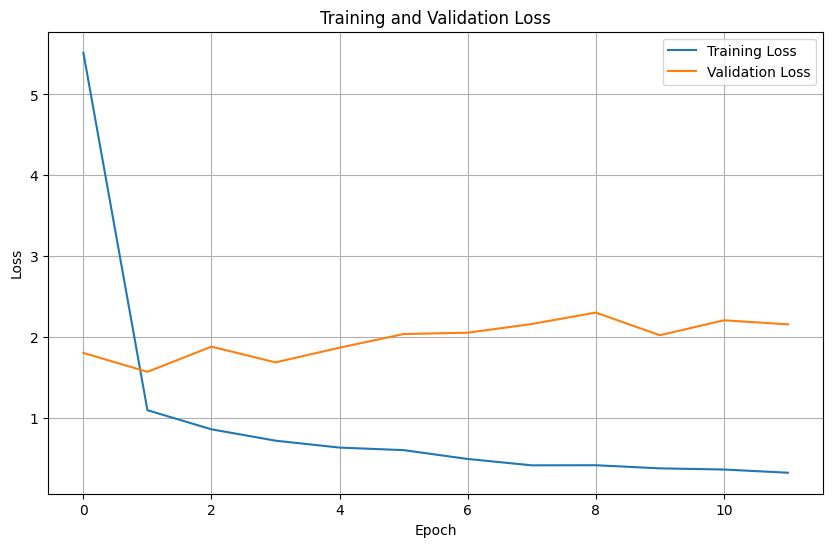

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

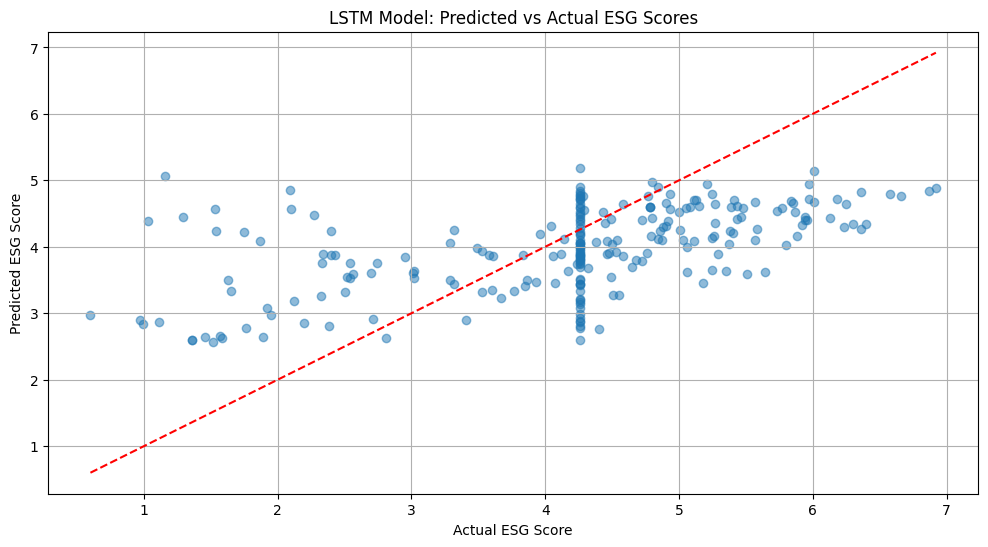

In [ ]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.scatter(targets, predictions, alpha=0.5)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
plt.xlabel('Actual ESG Score')
plt.ylabel('Predicted ESG Score')
plt.title('LSTM Model: Predicted vs Actual ESG Scores')
plt.grid(True)
plt.show()

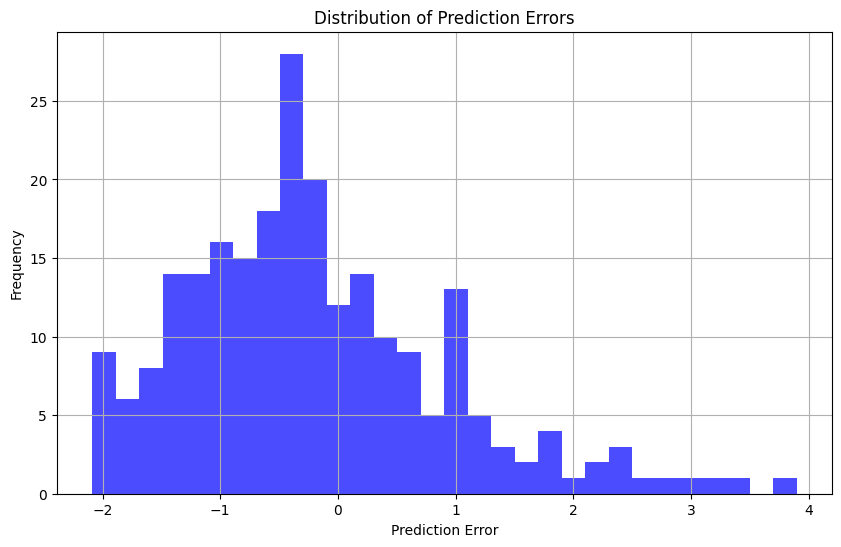

In [ ]:
# Plot error distribution
errors = predictions - targets
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, color='blue')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()

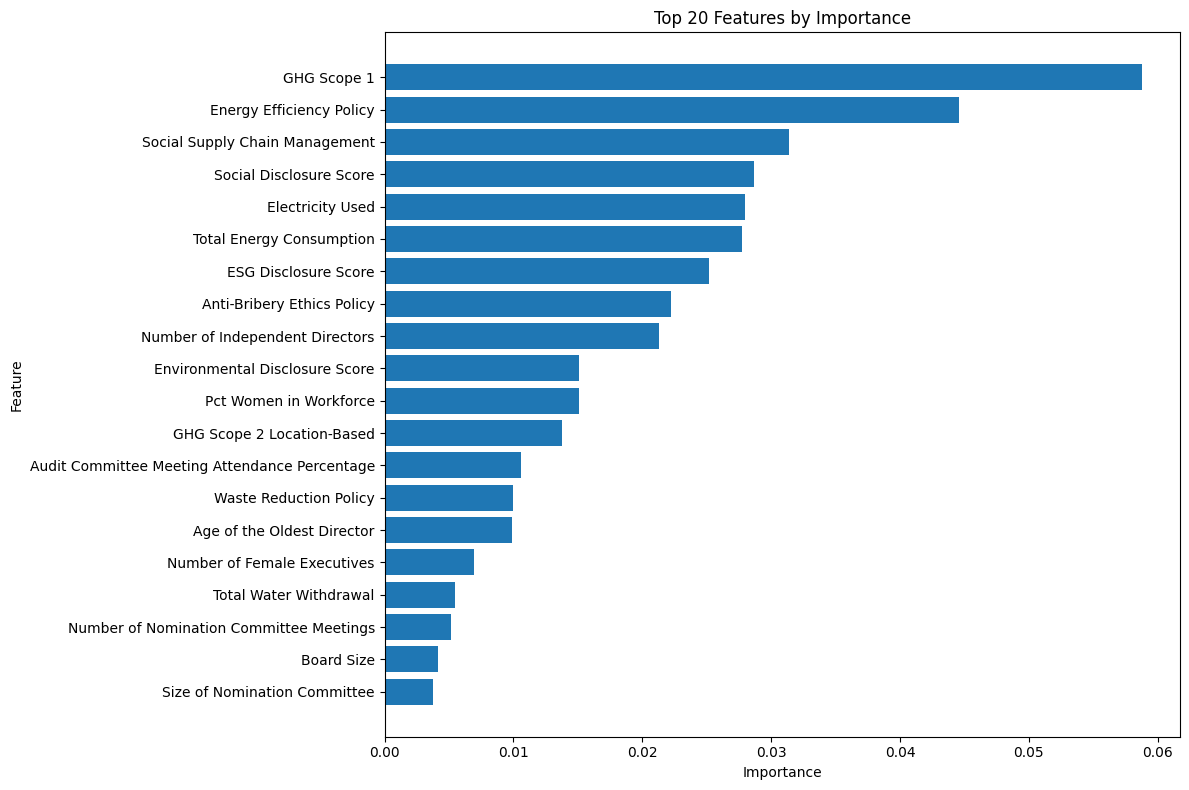

In [ ]:
def analyze_lstm_feature_importance(model, X_test, feature_names, device, n_permutations=10):
    """
    Analyze feature importance using permutation importance
    """
    model.to(device)
    model.eval()

    # Create a dataset with the first sequence_length samples
    seq_length = 3
    X_seq = X_test[:seq_length]
    X_tensor = torch.tensor(X_seq, dtype=torch.float32).unsqueeze(0).to(device)

    # Get baseline prediction
    with torch.no_grad():
        baseline_pred = model(X_tensor).item()

    # Calculate importance for each feature
    importance = {}

    for i, feature_name in enumerate(feature_names):
        feature_importance = 0

        for _ in range(n_permutations):
            # Create a copy of the sequence
            X_permuted = X_seq.copy()

            # Permute the feature across the sequence
            permuted_values = np.random.permutation(X_permuted[:, i])
            X_permuted[:, i] = permuted_values

            # Convert to tensor
            X_permuted_tensor = torch.tensor(X_permuted, dtype=torch.float32).unsqueeze(0).to(device)

            # Get prediction with permuted feature
            with torch.no_grad():
                permuted_pred = model(X_permuted_tensor).item()

            # Calculate importance as absolute difference
            feature_importance += abs(baseline_pred - permuted_pred)

        # Average over permutations
        importance[feature_name] = feature_importance / n_permutations

    # Sort by importance
    importance = {k: v for k, v in sorted(importance.items(), key=lambda item: item[1], reverse=True)}

    return importance

# Get feature names
feature_names = list(pd.get_dummies(data.drop(['BESG ESG Score', 'Company', 'Year'], axis=1)).columns)

# Analyze feature importance
feature_importance = analyze_lstm_feature_importance(model, X_test, feature_names, device)

# Plot top 20 features
top_n = 20
plt.figure(figsize=(12, 8))
top_features = list(feature_importance.keys())[:top_n]
top_values = list(feature_importance.values())[:top_n]

plt.barh(top_features, top_values)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Features by Importance')
plt.gca().invert_yaxis()  # Display the most important at the top
plt.tight_layout()
plt.show()